In [54]:
import pandas as pd
import numpy as np
import matplotlib
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter

# Домашнее задание #4 [70 баллов]

**Hard deadline: 23:59 28 апреля**

В этом домашнем задании мы предлагаем вам реализовать алгоритм LinUCB --- алгоритм, который решает задачу Contextual Bandits (бандиты с контекстом). Этот алгоритм придумала команда Yahoo research для оптимизации системы рекомендации новостей на главной. [Ссылка на оригинальную статью
](https://arxiv.org/pdf/1003.0146.pdf)


## Подготовка данных

Начнем с данных. В этом задании вы будете работать с упрощенным датасетом рекоммендаций новостей. Этот датасет состоит из $t = 10,000$ наблюдение. Каждое наблюдение характеризуется 102 переменными:
- `ActualAction` $ \in \{1, 2, 3, \ldots, 10\}$. Индекс новости, которая была действительно показана пользователю в эксперименте
- `Reward` $ \in \{0, 1\}$. Награда, которая равна 1 если пользователь кликнул новость и 0 иначе
- `F1, F2, ..., F100` Контекст, описывающий пользователя

Код ниже загружает датасет в Google Colab.

In [2]:
# Не меняйте этот код

# Скачаем данные в локальную директорию, с которой можно работать прямо из Colab
!gdown '1e7syyRL7kd_M-6Uc-M31HFIwV8gpuTr5'

Downloading...
From: https://drive.google.com/uc?id=1e7syyRL7kd_M-6Uc-M31HFIwV8gpuTr5
To: /content/hw4_data.txt
100% 2.15M/2.15M [00:00<00:00, 99.7MB/s]


In [3]:
# Не меняйте этот код

df = pd.read_csv('/content/hw4_data.txt', header=None, index_col=False, sep=' ',
                 names=["ActualAction", "Reward"] + [f"F{i}" for i in range(1, 101)])

Датасет, с которым вы работаете в этом задании был собран в режиме **random policy**: каждому пользователю показывалась случайная новость $a \in \{1, 2, 3, \ldots, 10 \}$.

Посмотрим на частоту выбора каждого действия и на общую долю кликов.

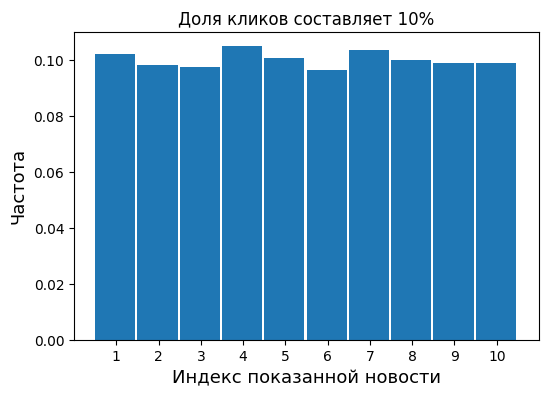

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(df["ActualAction"], width=0.95, bins=[0.5 + x for x in range(11)],
        align='mid', density=True)
_ = ax.set_xticks([x for x in range(1, 11)])
_ = ax.set_xlabel("Индекс показанной новости", fontsize=13)
_ = ax.set_ylabel("Частота", fontsize=13)
ax.set_title(f"Доля кликов составляет {round(100 * np.mean(df['Reward']))}%");

## Идея задания

В этой работе мы исследуем два алгоритма: UCB-1 (разминка) и LinUCB (основное задание).

**Наша задача** Просимулировать обучение алгоритма в *online-режиме* (в порядке прихода пользователей), используя *offline-данные* (мы не знаем, что было бы, если бы для пользователя $t$ мы сделали другое предсказание).

**Наша метрика**  Click Trough Rate (CTR), то есть доля пользователей, которые кликнули на предложенную новость. Например, CTR случайного правила равен 10% (см. график выше).

**Подход к предсказанию**  Для предсказания новости на шаге $t$ алгоритмы будут использовать всю имеющуюся информацию (все данные из раундов $1, \ldots, t-1$).

**Подход к оценке алгоритма**  Для оценки CTR на момент $t$ мы будем использовать все раунды от 1 до $t$ в которых предсказания алгоритма совпадали с фактически показанными новостями. Введем некоторые обозначения:
- $a_t^*$ -- фактическая новость, показанная в раунде $t$
- $r_t$ -- фактический reward в раунде $t$
- $\hat{a}_t$ -- новость, которую наш алгоритм показал бы в раунде $t$

Тогда для любого раунда $t$ текущий CTR нашего алгоритма подсчитывается следующим образом:
$$\text{CTR}_t = \frac{\sum\limits_{i=1}^t r_t \times \mathbb{I} [a_t^* = \hat{a}_t]}{\sum\limits_{i=1}^t \mathbb{I} [a_t^* = \hat{a}_t]} $$


## Разминка. UCB-1 [30 баллов]

Начнем с простого: алгоритма UCB-1.

**Алгоритм UCB-1**

Для начала попробуем использовать алгоритм UCB-1, который игнорирует контексты, то есть считает, что награда в раунде $t$ зависит только от выбранного действия, но не от контекста:
$$r_t \sim \mathcal{P}(a_t).$$

**Псевдокод алгоритма**

Параметр алгоритма: $\alpha$

Шаг 1. Устанавливаем Upper Confidence Bound (UCB) каждой новости в бесконечность

Шаг 2. Для каждого раунда от 1 до T:

- A. Выбираем новость $\hat{a}$ с наибольшей UCB (в случае ничьей выбираем случайно)

- B. Наблюдаем фактически показанную новость $a^*$ и фактический reward $r$

- С. Обновляем UCB новости $a^*$ (так как информацию мы получили по ней):
$$\text{UCB}' = \bar{r_t}(a^*) + \alpha \sqrt{\frac{1}{n_t(a^*)}}$$ Здесь $\bar{r_t}(a^{\ast})$ это CTR новости $a^{\ast}$ на момент $t$, а $n_t(a^*)$ это количество показов новости $a^{\ast}$ на момент $t$

- D. Подсчитываем $\text{CTR}_t$ для нашего алгоритма


**<font color='orange'>Задание</font>**

1. Реализуйте алгоритм UCB-1

2. Обучите алгоритм UCB-1 на наших данных с разными параметрами $\alpha$. Постройте графики $\text{CTR}_t$ для разных параметров на одном рисунке

3. Сравните UCB-1 с случайным алгоритмом

4. Напишите развернутый комментарий, объясняющий пункты 2 и 3. В чем смысл параметра $\alpha$?


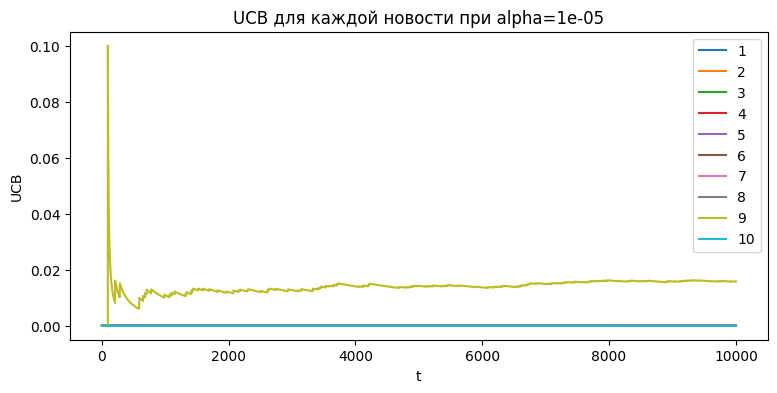

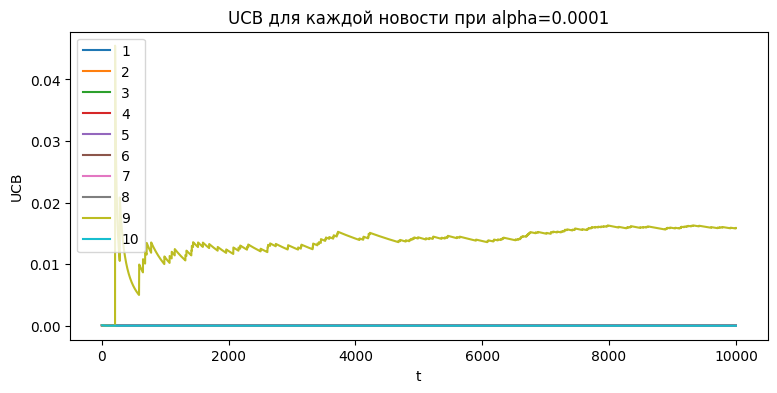

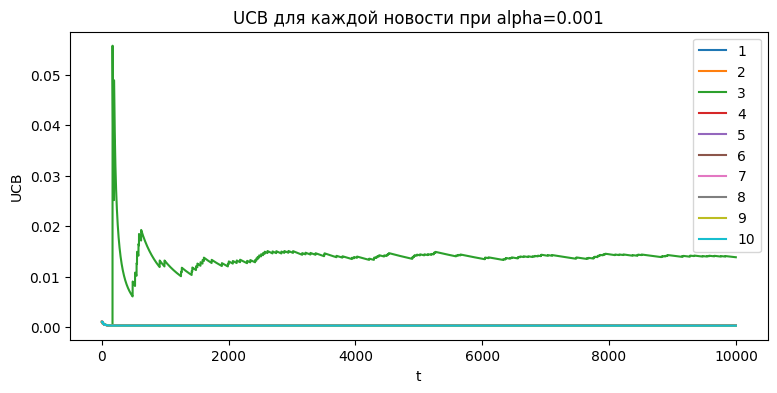

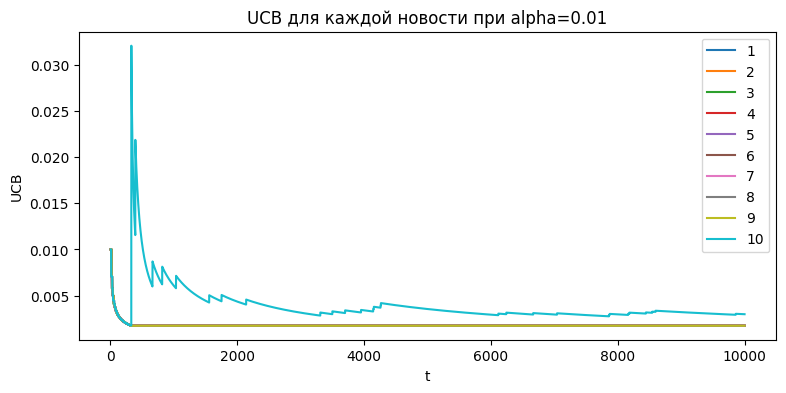

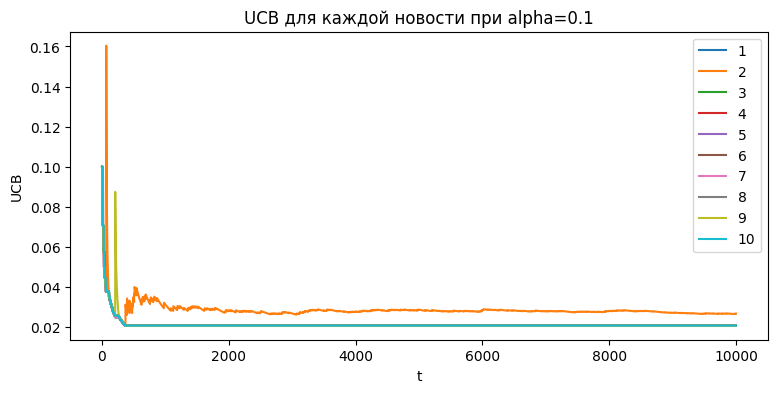

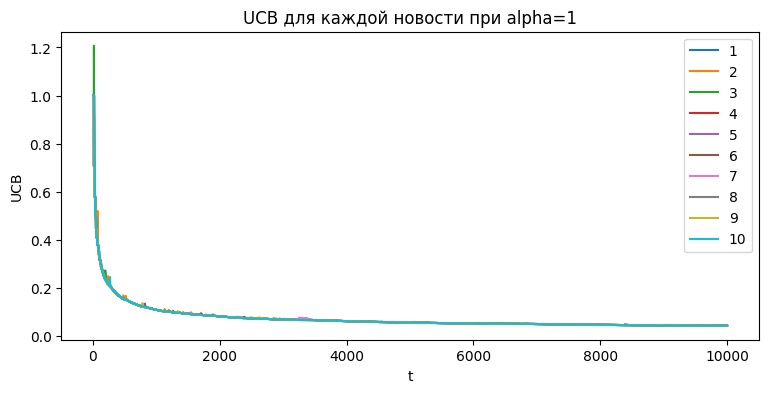

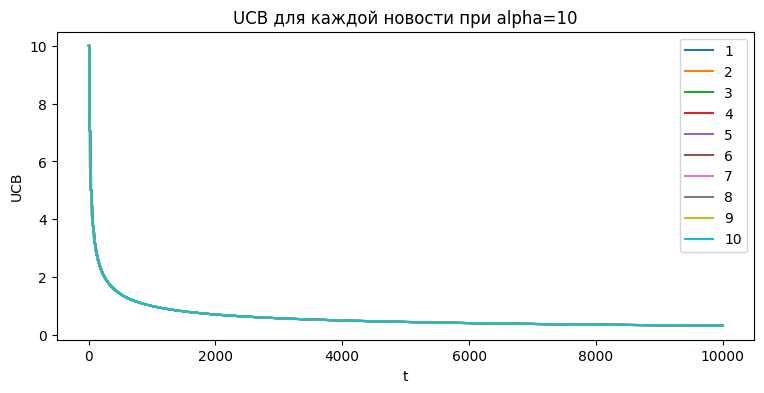

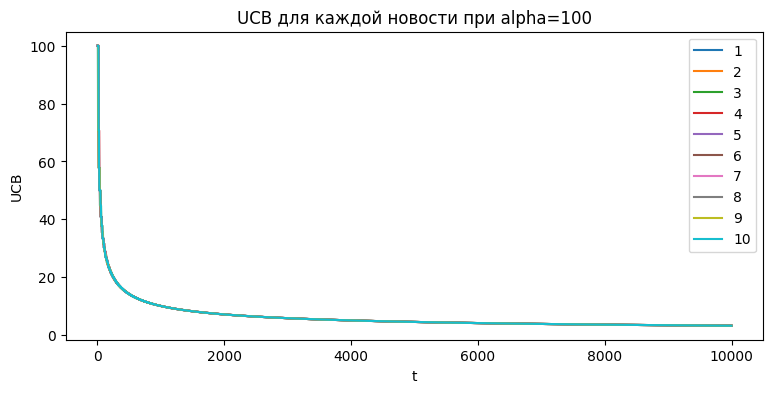

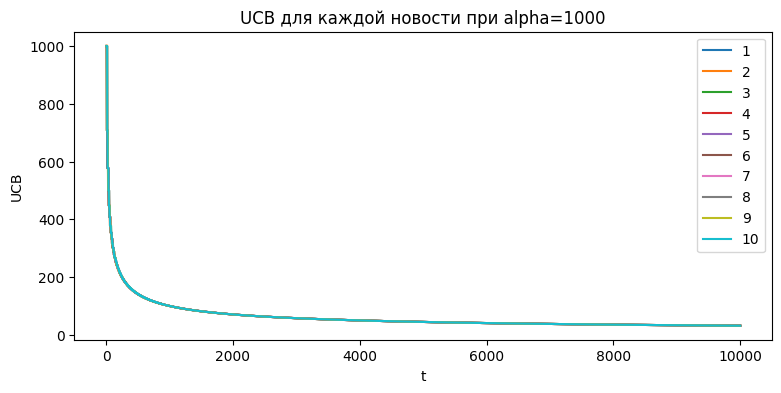

In [ ]:
# ваш код и комментарии в блоках ниже

def choose_new(dct):
    """
    Функция для выбора лучшей новости
    """
    bests = []
    temp_max = max(list(dct.values()))
    for it in dct:
        if dct[it] == temp_max:
            bests.append(it)

    return random.choice(bests)


def update_bound(dct_up, dct_ucb):
    """
    Функция, хранящая для каждой новости верхнюю грань в каждый момент t
    """
    for a in range(1, 11):
        dct_up[a].append(dct_ucb[a])


def ctr_for_news(dct_success, dct_n_t, a):
    """
    Подсчет ctr для каждой новости
    """
    if dct_n_t[a] == 0:
        return float('inf')
    return dct_success[a] / dct_n_t[a]


def update_ucb(dct_ucb, dct_success, dct_n_t, a, alpha):
    """
    Обновление UCB новости
    """
    dct_ucb[a] = ctr_for_news(dct_success, dct_n_t, a) + alpha * np.sqrt(1 / dct_n_t[a])


def show_bounds(dct_up, alpha):
    plt.figure(figsize=(9, 4))

    for a in range(1, 11):
        plt.plot(dct_up[a], label=f'{a}')

    plt.legend()
    plt.title(f'UCB для каждой новости при alpha={alpha}')
    plt.xlabel('t')
    plt.ylabel('UCB')
    plt.show();


def show_ctr(ctr, alpha):
    plt.plot(ctr)
    plt.title('CTR')
    plt.xlabel('t')
    plt.title(f'CTR в моменты t при alpha={alpha}')
    plt.show();

all_ctr = []
all_alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for alpha in all_alpha:

    dct_ucb = dict() # Будем считать UCB для каждой новости

    dct_n_t = dict() # Встречаемость новости

    dct_up = dict()

    predict = np.array([], dtype=int) # Наш предикт
    real_t = np.array(df.ActualAction, dtype=int)
    temp_real = np.array([])
    dct_success = dict() # Если выдали верную новость, запишем сюда
    ctr_t = []

    for a in range(1, 11):
        dct_ucb[a] = float('inf')
        dct_n_t[a] = 0
        dct_success[a] = 0
        dct_up[a] = []

    good_n = 0 # Верно предсказанные новости (для подсчета текущего CTR)


    for t in range(10000):
        res = choose_new(dct_ucb)

        if res == real_t[t]: # Если совпало с реальной новостью, то добавляем reward по ней
            temp_reward = df[df.index == t]['Reward'][t]
            dct_success[res] += temp_reward
            good_n += temp_reward

        dct_n_t[res] += 1
        update_ucb(dct_ucb, dct_success, dct_n_t, res, alpha)
        predict = np.append(predict, res)
        ctr_t.append(good_n / (t + 1))

        update_bound(dct_up, dct_ucb)


    # Теперь визуализируем
    show_bounds(dct_up, alpha)
    print()
    #show_ctr(ctr_t, alpha)
    all_ctr.append(ctr_t)


Теперь запустим рандом

In [ ]:
n_random = 0
ctr_random = []
news = list(range(1, 11))

for t in range(10000):
    res = random.choice(news)
    if res == df[df.index == t]['ActualAction'][t]:
        n_random += df[df.index == t]['Reward'][t]
    ctr_random.append(n_random / (t + 1))

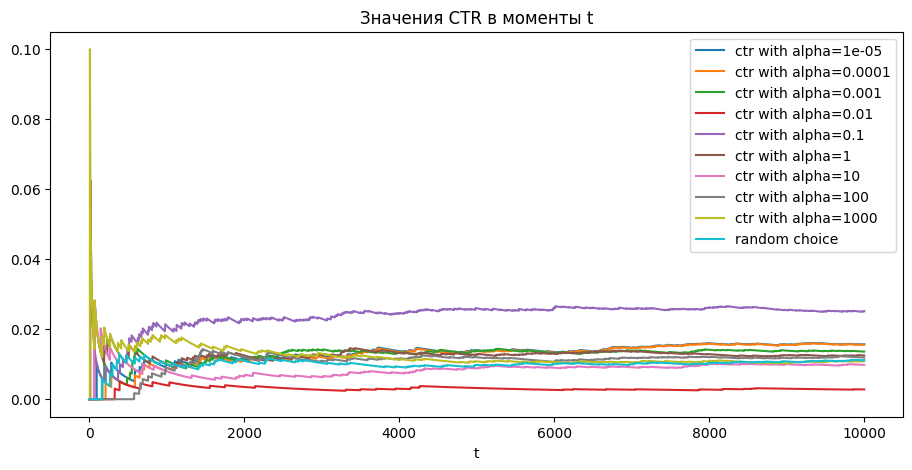

In [ ]:
plt.figure(figsize=(11, 5))
best_alpha = 0
best_ctr = 0
for i in range(len(all_ctr)):
    plt.plot(all_ctr[i], label=f'ctr with alpha={all_alpha[i]}')
    if all_ctr[i][-1] > best_ctr:
        best_ctr = all_ctr[i][-1]
        best_alpha = all_alpha[i]

plt.plot(ctr_random, label='random choice')
plt.xlabel('t')
plt.title('Значения CTR в моменты t')
plt.legend();

In [ ]:
print(f'Best_alpha = {best_alpha}')
print(f'Best_CTR = {best_ctr}')

Best_alpha = 0.1
Best_CTR = 0.0252


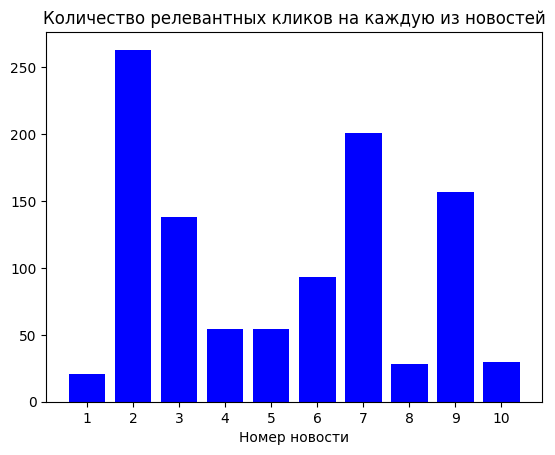

In [ ]:
for i in range(1, 11):
    plt.bar(i, df[(df.Reward == 1) & (df.ActualAction == i)].shape[0], color='b')

plt.xticks(range(1, 11))
plt.xlabel('Номер новости')
plt.title('Количество релевантных кликов на каждую из новостей');

In [ ]:
bad_alpha = []
for i in range(len(all_ctr)):
    if all_ctr[i][-1] < ctr_random[-1]:
        bad_alpha.append(all_alpha[i])

print(f'Рандом показывает себя лучше чем UCB-1 при alpha из {bad_alpha}')

Рандом показывает себя лучше чем UCB-1 при alpha из [0.01, 10, 1000]


Из ячейки над этой видно, что вторая, третья, седьмая и девятая новости чаще других давали reward = 1, поэтому если посмотреть выше на графики upper_bound новостей, можно заметить как вторая (оранжевый цвет), третья (зеленый цвет), седьмая (розовый цвет) и девятая (болотный цвет) при некоторых альфа выбивались вверх.

\

Насчет параметра альфа и рандома, кажется, что логика следующая: при достаточно больших альфа у нас в формуле upper bound

$$\text{UCB}' = \bar{r_t}(a^*) + \alpha \sqrt{\frac{1}{n_t(a^*)}}$$

Больший вклад начинает вносить второе слагаемое, то есть мы начинаем выбирать ту новость, которая просто встречалась реже остальных, а на ее CTR забиваем (что является ошибкой), то есть в итоге мы больше внимания уделяем встречаемости новости, чем ее релевантности. Поэтому при больших альфа UCB-1 хуже рандома.

\

Эту логику также можно проследить и в графиках upper bound, при больших альфа, у нас все upper bound просто становятся одинаковыми для всех новостей и по факту мы и получаем тот же рандом. При маленьких альфа у нас в лучшую новость могут выбиться не самые лучшие новости (третья, седьмая и девятая), а при оптимальном альфа у нас выбивается в лучшую новость вторая, которая самая релевантная.

## Основной алгоритм. LinUCB [40 баллов]

Теперь реализуем алгоритм, который учитывает контекст ---  LinUCB. Этот алгоритм построен на нескольких основных предположениях/идеях.

**Предположение/идея 1** Будем считатать, что матожидание награды для каждой пары (контекст $x$, действие $a$) определяется линейной моделью:
$$ \mathbb{E}[r | x, a] = x^T \theta_a, $$ где $x \in \mathbb{R}^d$ это вектор контекста,  а $\theta_a \in \mathbb{R}^d$ - неизвестный вектор, описывающий действие $a$ (для каждого действия он свой)

**Предположение/идея 2** Основная идея алгоритма --- попытаться оценить $\theta_a$ в процессе обучения. Для этого применяется линейная модель Ridge Regression.

Пусть в раундах $1, \ldots, t$ действие $a$ было фактически выбрано $m$ раз. Тогда запишем все соответствующие контексты в матрицу $D_a$ размера $m \times d$, а все соответствующие значения reward в вектор $c_a \in R^d$. Теперь применим Ridge Regression для оценки параметра $\theta_a$:
$$\hat{\theta}_a = (D_a^T D_a + I)^{-1} D_a^T c_a$$

**Предположение/идея 3** Аналогично алгоритму UCB-1, в каждом раунде будем выбирать действие с самой оптимистичной верхней границей на матожидание reward:
$$\hat{a}_t = \arg\max\limits_a \left[x^T \hat{\theta}_a + \alpha \sqrt{x^T (D_a^T D_a + I)^{-1} x^T} \right]$$ Здесь первое слагаемое это оценка мат. ожидания reward от действия $a$ (идея 1), а второе --- оценка дисперсии, следующая из свойств Ridge Regression.

**<font color='orange'>Задание</font>**

1. Реализуйте алгоритм LinUCB

2. Обучите алгоритм LinUCB на наших данных с разными параметрами $\alpha$. Постройте графики $\text{CTR}_t$ для разных параметров на одном рисунке

3. Сравните LinUCB с случайным алгоритмом и UCB-1

4. Напишите развернутый комментарий, объясняющий пункты 2 и 3. В чем смысла параметра $\alpha$?

**Подсказка** Для эффективной имплементации удобно ввести дополнительные матрицу и вектор:
$$A_a =  (D_a^T D_a + I)^{-1}, \ b_a = D_a^T c_a.$$

- В таких обозначениях выражения, введенные выше, упрощаются:
$$\hat{\theta}_a = A_a^{-1} b_a $$
$$x^T \hat{\theta}_a + \alpha \sqrt{x^T (D_a^T D_a + I)^{-1} x^T} = x^T \hat{\theta}_a + \alpha \sqrt{x^T (A_a)^{-1} x^T} $$

- Новые объекты $A_a$ и $b_a$ легко обновлять после нового наблюдения $(x, a, r)$:
$$A_a' = A_a + x \cdot x^T, b_a' = b_a + r x$$

In [29]:
# ваш код и комментарии в блоках ниже

df.head()

,ActualAction,Reward,F1,F2,F3,F4,F5,F6,F7,F8,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100
0,2,0,5,0,0,37,6,0,0,0,...,0,0,1,3,0,0,17,30,4,0
1,8,0,1,3,36,0,0,0,0,0,...,0,0,3,0,1,5,1,0,0,10
2,5,0,3,0,0,0,0,0,0,0,...,0,0,0,0,23,0,11,3,0,0
3,4,0,77,0,0,13,0,0,0,0,...,0,5,0,0,0,2,4,0,0,0
4,2,1,43,0,2,44,1,0,0,0,...,0,0,0,0,0,0,0,13,0,0


In [48]:
d = 100
alpha = 0.01
all_alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
all_ctr = []
all_actions = []

for alpha in tqdm(all_alpha):
    A = [np.identity(100)] * 10
    b = [np.zeros(100)] * 10
    theta = [np.zeros(100)] * 10
    p = [0] * 10
    our_a = []

    set_a = set()
    t = 0
    good_a = 0
    ctr_t_ = []

    for a in df.iterrows():
        a, r, context = a[1][0], a[1][1], np.array(list(a[1][2:]))
        if a == a_t:
            good_a += r
        t += 1
        ctr_t_.append(good_a / t)
        if a not in set_a:
            set_a.add(a)
            A[a - 1] = np.identity(100)
            b[a - 1] = np.zeros(100)

        theta[a - 1] = np.linalg.inv(A[a - 1]) @ b[a - 1]
        p[a - 1] = theta[a - 1] @ context + alpha * np.sqrt(context @ np.linalg.inv(A[a - 1]) @ context)

        a_t = np.argmax(p)
        A[a_t] += context @ context
        b[a_t] += r * context

        our_a.append(a_t)

    all_ctr.append(ctr_t_)
    all_actions.append(our_a)


100%|██████████| 11/11 [02:59<00:00, 16.30s/it]


In [90]:
n_random = 0
ctr_random = []
news = list(range(1, 11))

for t in range(10000):
    res = random.choice(news)
    if res == df[df.index == t]['ActualAction'][t]:
        n_random += df[df.index == t]['Reward'][t]
    ctr_random.append(n_random / (t + 1))

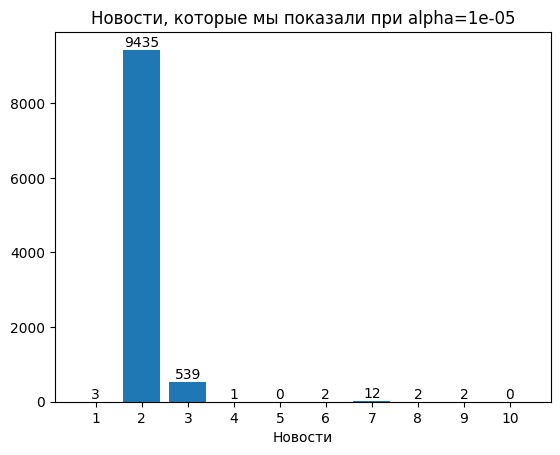

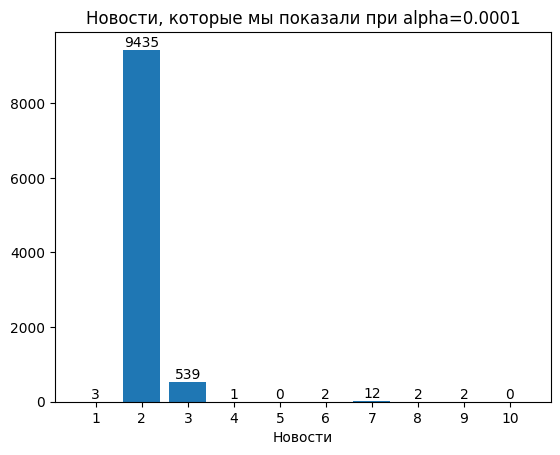

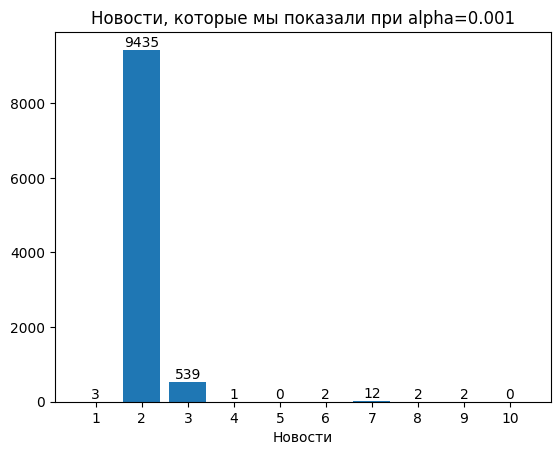

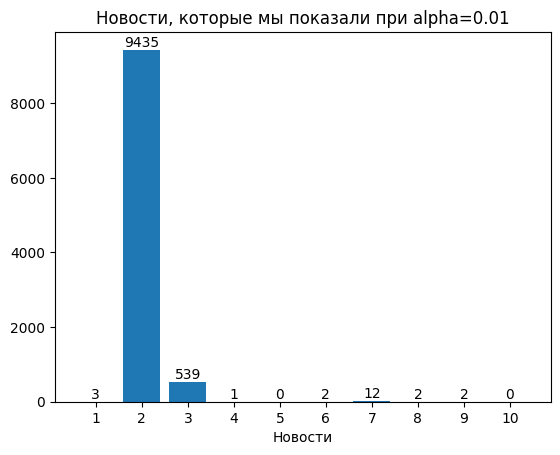

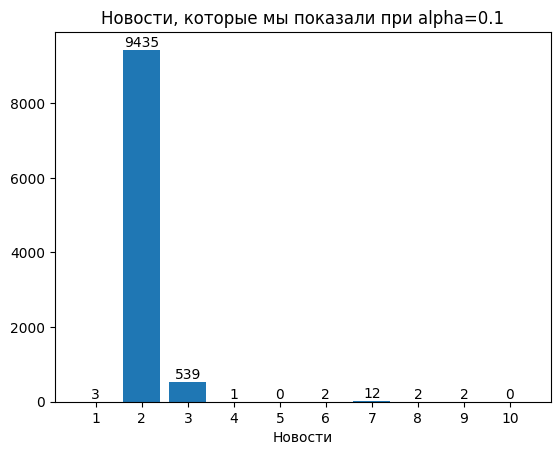

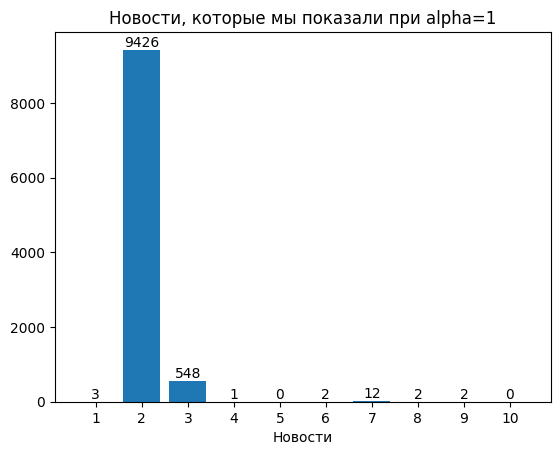

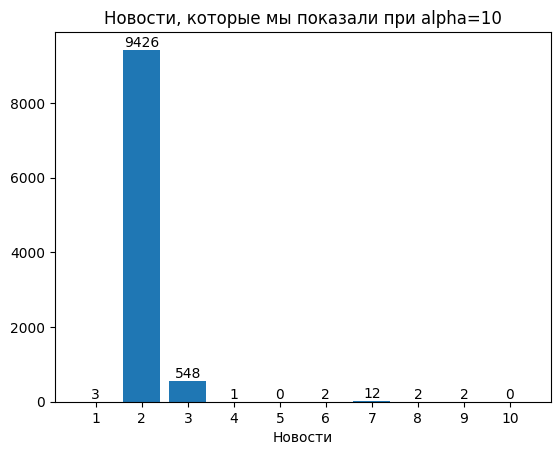

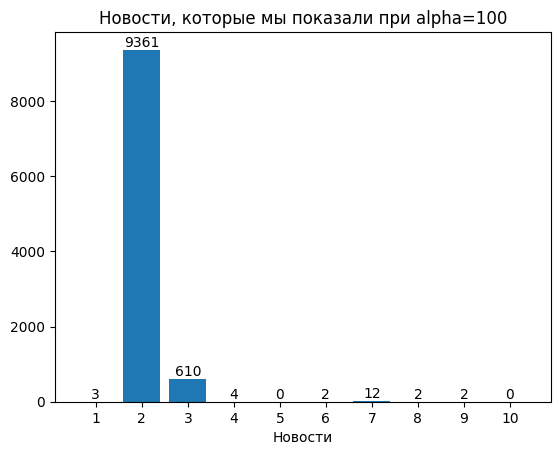

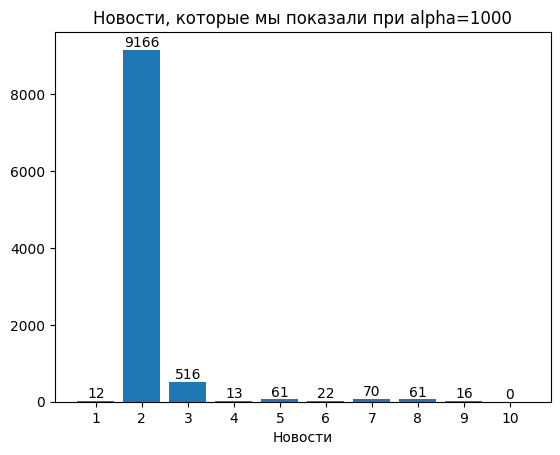

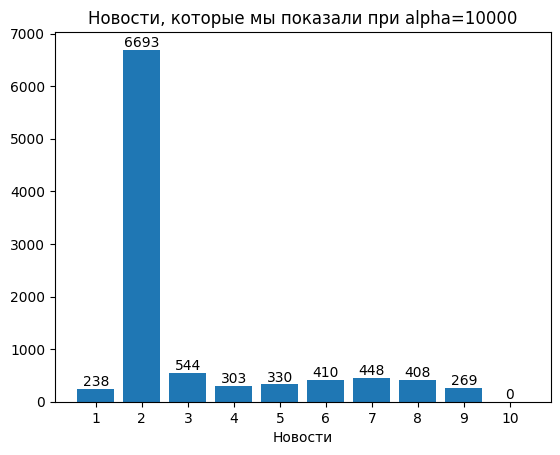

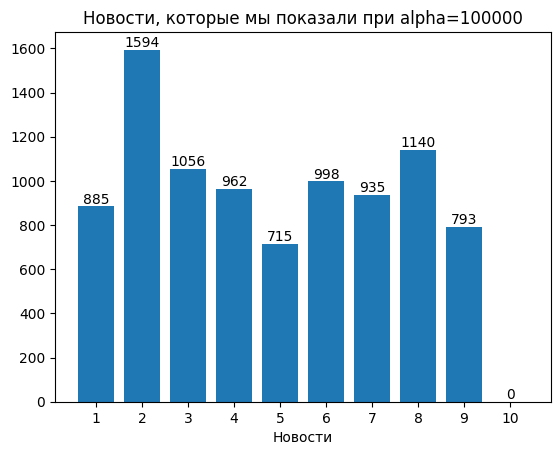

In [85]:
j = 0
for actions in all_actions:
    dct_ = Counter(actions)
    y = []
    for i in range(1, 11):
        if i in dct_:
            y.append(dct_[i])
        else:
            y.append(0)

    plt.bar(range(1, 11), y)
    for i, value in zip(range(1, 11), y):
        plt.text(i, value, str(value), ha='center', va='bottom')

    plt.xticks(range(1, 11), range(1, 11))
    plt.title(f'Новости, которые мы показали при alpha={all_alpha[j]}')
    plt.xlabel('Новости')
    plt.show();
    print()
    print()
    j += 1

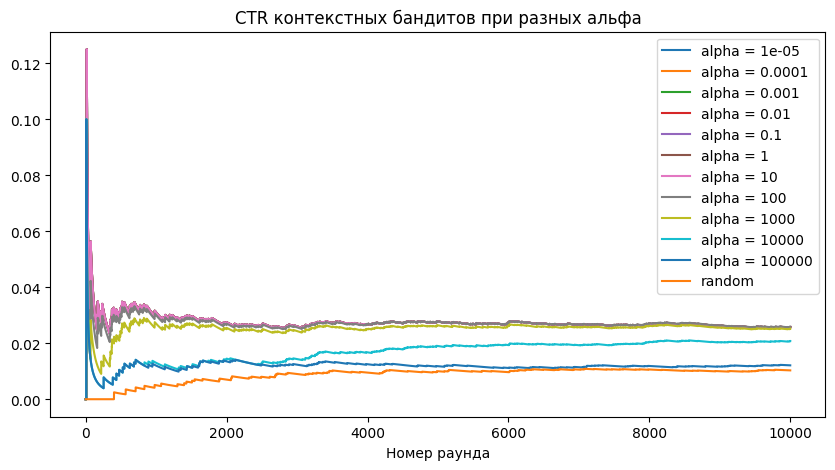

In [92]:
plt.figure(figsize=(10, 5))
for i in range(len(all_ctr)):
    plt.plot(all_ctr[i], label=f'alpha = {all_alpha[i]}')

plt.plot(ctr_random, label='random')
plt.legend()
plt.title('CTR контекстных бандитов при разных альфа')
plt.xlabel('Номер раунда');

In [88]:
for i in range(len(all_ctr)):
    print(f'alpha = {all_alpha[i]}, CTR = {all_ctr[i][-1]}')

alpha = 1e-05, CTR = 0.0258
alpha = 0.0001, CTR = 0.0258
alpha = 0.001, CTR = 0.0258
alpha = 0.01, CTR = 0.0258
alpha = 0.1, CTR = 0.0258
alpha = 1, CTR = 0.0258
alpha = 10, CTR = 0.0258
alpha = 100, CTR = 0.0259
alpha = 1000, CTR = 0.0252
alpha = 10000, CTR = 0.0208
alpha = 100000, CTR = 0.0121


In [89]:
print('Best alpha = 100')
print('Best CTR = 0.0259')

Best alpha = 100
Best CTR = 0.0259


**Итоги:** LinUCB показал себя лучше, чем UCB-1. Также хочется заметить, что LinUCB более устойчив к параметру $\alpha$. Если честно, не до конца понятна суть параметра $\alpha$, так как оба слагаемых у выражения под $a_t$ у аргмакса имеют очень похожую структуру.

Первое слагаемое:

$x^T \hat{\theta_a} = x^T (D_a^T D_a + I)^{-1} D_a^T c_a$

Второе слагаемое:

$\alpha\sqrt{x^T (D_a^T D_a + I)^{-1}x^T}$

\

Но судя по структуре слагаемых, первое больше учитывает reward, а второе текущий контекст, и параметр альфа регулирует значимость одного из этих показателей.